<a href="https://colab.research.google.com/github/Roudranil/competitions/blob/main/Kaggle/Tabular%20Playground%20March/tab_playground_mar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. *`libraries and dataset`*
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

In [ ]:
!pip install h2o

In [ ]:
!pip install optuna

In [ ]:
!pip install featuretools

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier as xgbc
from lightgbm import LGBMClassifier as lgbc
from catboost import CatBoostClassifier as ctbc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.metrics import auc, roc_auc_score

from sklearn.model_selection import KFold

import optuna
import featuretools as ft
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = 12,12

In [ ]:
import h2o
h2o.init()

In [80]:
traindata = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/train.csv', index_col=0)
testdata = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/test.csv', index_col=0)
submission = pd.read_csv('/content/drive/MyDrive/data/kaggle_tabplayground_mar/sample_submission.csv', index_col=0)

In [81]:
traindf = traindata
testdf = testdata

In [24]:
traintest = pd.concat([traindata.drop(columns=['target']), testdata])

In [18]:
traindata.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [19]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 499999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [20]:
traindata.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


In [21]:
testdata.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.505388,0.493960,0.516425,0.475286,0.504772,0.501180,0.487315,0.502684,0.488331,0.469813,0.508974
std,0.207417,0.212695,0.214752,0.216919,0.227199,0.241375,0.211335,0.203793,0.178895,0.194999,0.203926
min,-0.044929,0.090478,0.098591,-0.038178,0.171321,-0.036337,-0.005648,0.096067,0.013554,0.215540,0.113059
25%,0.344748,0.317788,0.326210,0.292777,0.279413,0.275422,0.322365,0.353388,0.359121,0.309888,0.368999
50%,0.479633,0.463195,0.470893,0.392118,0.480299,0.554723,0.517318,0.436139,0.411318,0.407066,0.446578
75%,0.638773,0.693882,0.704745,0.645803,0.725272,0.735137,0.607454,0.646104,0.612508,0.588008,0.583082
max,1.006825,1.011597,1.012128,0.965609,0.867198,0.848617,0.964635,1.033760,1.053155,1.007189,1.007168


#2. *`EDA`*
*   *categorical columns to drop: 5,9,13*
*   *numerical columns to drop: 2,7,10*
*   *After one-hot-encoding, it may turn out some new features are almost always zero and have negligible statistical significance and you can just drop them*
---

In [85]:
numcols = [col for col in traindf.columns if traindf[col].dtype != 'object']
catcols = [col for col in traindf.columns if col not in numcols]

In [ ]:
idx = 1
f, axes = plt.subplots(5, 2, figsize=(20,20))
plt.suptitle('Categorical features distribution', size=16, y=(0.94))

for row in range(5):
    for col in range(2):
        data = traindf[catcols[idx]].value_counts()
        sns.barplot(x = data.values, y = data.index, palette='deep', ax=axes[row, col])
        axes[row, col].set_title(catcols[idx])
        idx += 1

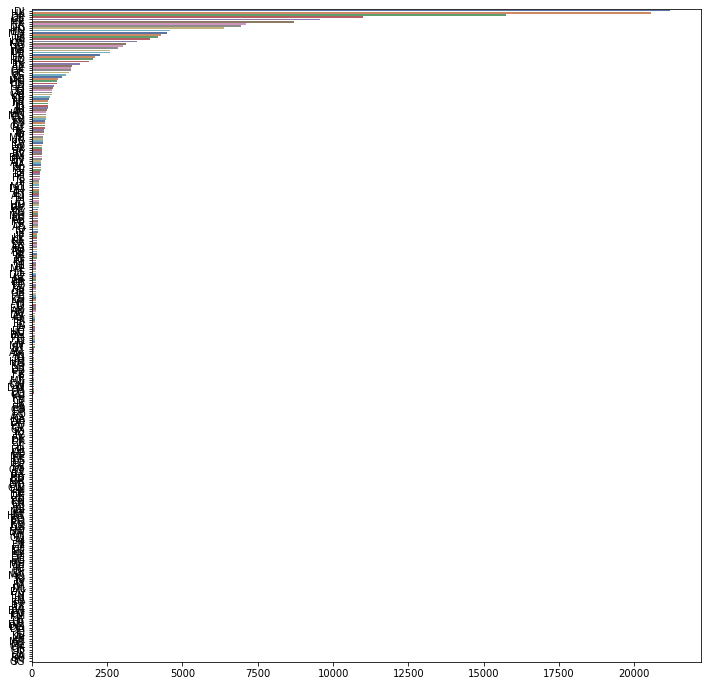

In [95]:
sns.figsize = (12,8)
data = testdf['cat10'].value_counts()
sns.barplot(x = data.values, y = data.index, palette='deep')

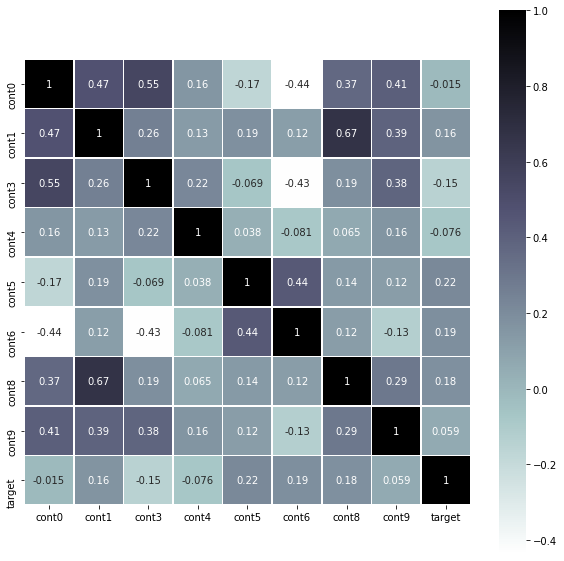

In [86]:
plt.figure(figsize=(10,10))
sns.heatmap(traindf[numcols].corr(), square=True, linewidths=0.7, cmap="bone_r", annot=True);

In [93]:
toomanyfeat = [f'cat{i}' for i in range(1, 11)]

In [ ]:
for col in toomanyfeat:
    

In [82]:
# final after drops and all
traindf.drop(columns=['cat5', 'cat9', 'cat13', 'cont2', 'cont7', 'cont10'], inplace=True)
testdf.drop(columns=['cat5', 'cat9', 'cat13', 'cont2', 'cont7', 'cont10'], inplace=True)

#3. *`encodings`*
---

#4. *`training`*
---

In [26]:
X = traindata.drop(columns=['target'])
y = traindata['target']

In [27]:
lr = LogisticRegression()
lr.fit(X, y)
pred = lr.predict_proba(X)[:, 1]
roc_auc_score(y, pred)

ValueError: ignored

#5. *`submission`*
---